# More Data Cleaning -> Feature Engineering -> Sentiment Analysis
1) Determine the language of each transcript

2) Get runtime and rating info from IMDb 

3) Remove whitespace

4) Remove any unwanted characters

5) Split transcripts into sentences and words with NLTK and count them

6) Perform sentiment analysis with TextBlob

7) Count swear words

KDE plots are used throughout to make sure everything looks right. Quickly viewing a simple distribution can be a great indicator that the code and data are performing as expected.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

In [2]:
df = pd.read_csv('stand-up-data.csv')
df.head()

,title,date_posted,link,name,year,transcript
0,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESENT...
1,T.J. Miller: No Real Reason,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/t-j-m...,T.J. Miller,2011.0,"– I wish I didnt have to do this to perform, b..."
2,Jerry Seinfeld: 23 Hours To Kill,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/jerry...,Jerry Seinfeld,2020.0,"Jerry Seinfelds new hourlong comedy special, J..."
3,Bill Burr On The Late Show With David Letterma...,"May 5th, 2020",https://scrapsfromtheloft.com/2020/05/05/bill-...,Bill Burr,2010.0,Bill Burr performing on The Late Show with Dav...
4,Sincerely Louis Ck,"May 2nd, 2020",https://scrapsfromtheloft.com/2020/05/02/since...,Louis C.K.,2020.0,Great comedy is finally back. Louis C.K. is no...


### Use the langdetect library to id the languages of each transcript

In [3]:
from langdetect import detect

# Dectect language based on the first 500 characters and create a language column in the df
df['language'] = df.transcript.apply(lambda x: detect(x[:500]))

print(df.language.value_counts())
df.head()

en    318
it      7
es      1
Name: language, dtype: int64


,title,date_posted,link,name,year,transcript,language
0,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESENT...,en
1,T.J. Miller: No Real Reason,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/t-j-m...,T.J. Miller,2011.0,"– I wish I didnt have to do this to perform, b...",en
2,Jerry Seinfeld: 23 Hours To Kill,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/jerry...,Jerry Seinfeld,2020.0,"Jerry Seinfelds new hourlong comedy special, J...",en
3,Bill Burr On The Late Show With David Letterma...,"May 5th, 2020",https://scrapsfromtheloft.com/2020/05/05/bill-...,Bill Burr,2010.0,Bill Burr performing on The Late Show with Dav...,en
4,Sincerely Louis Ck,"May 2nd, 2020",https://scrapsfromtheloft.com/2020/05/02/since...,Louis C.K.,2020.0,Great comedy is finally back. Louis C.K. is no...,en


### Get runtime and rating info with an IMDb api
For the most part, only fully produced specials will have data on IMDb. Only 51 titles from our original set of 300+ were not found on IMDb.

In [4]:
import imdb

imdb = imdb.IMDb()

def get_imdb_info(titles):
    runtime = []
    rating = []
    count = -1
    errors = 0
    
    for i in titles:
        count += 1
        # Search the first 30 characters on IMDb
        result = imdb.search_movie(i[:30])
        try:
            mov = imdb.get_movie(result[0].movieID, info=['main'])
            runtime.append(int(mov.get('runtimes')[0]))
            rating.append(mov.get('rating'))
        except:
            runtime.append('')
            rating.append('')
            errors += 1
            # print(f'Error on index {count}, title: {i}') # Uncomment to investigate which titles were not found
    print(f'Total not found: {errors}')
    return pd.Series(runtime), pd.Series(rating)
    
runtime, rating = get_imdb_info(df.title)

df['runtime'] = runtime
df['rating'] = rating

# Replace empty values with NaN
df = df.replace(r'^\s*$', np.NaN, regex=True)

df.head()

Total not found: 51


,title,date_posted,link,name,year,transcript,language,runtime,rating
0,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESENT...,en,68.0,7.7
1,T.J. Miller: No Real Reason,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/t-j-m...,T.J. Miller,2011.0,"– I wish I didnt have to do this to perform, b...",en,67.0,7.1
2,Jerry Seinfeld: 23 Hours To Kill,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/jerry...,Jerry Seinfeld,2020.0,"Jerry Seinfelds new hourlong comedy special, J...",en,60.0,6.7
3,Bill Burr On The Late Show With David Letterma...,"May 5th, 2020",https://scrapsfromtheloft.com/2020/05/05/bill-...,Bill Burr,2010.0,Bill Burr performing on The Late Show with Dav...,en,NaN,NaN
4,Sincerely Louis Ck,"May 2nd, 2020",https://scrapsfromtheloft.com/2020/05/02/since...,Louis C.K.,2020.0,Great comedy is finally back. Louis C.K. is no...,en,60.0,8.5


### Perform some simple visualization to make sure everything looks right

Mean: 67.99272727272728
SD: 15.086657013225652


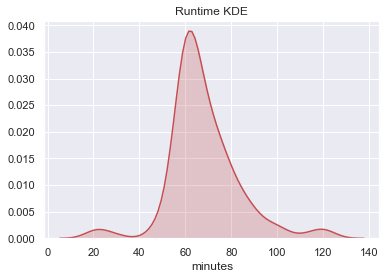

In [5]:
import numpy as np
import seaborn as sns; sns.set(color_codes=True)

# Stats and KDE plot for runtime of each performance
x = []
count = 0
for i in df.runtime:
    if (i > 0):
        count += 1
        x.append(int(i))
ax = sns.kdeplot(x, shade=True, color="r")   
ax.set_title('Runtime KDE')
ax.set(xlabel='minutes')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 7.3421818181818175
SD: 0.899920584191316


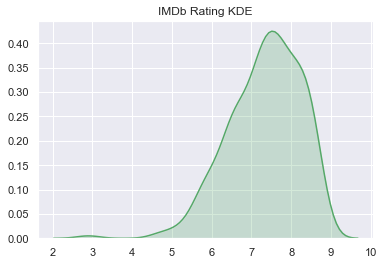

In [6]:
# Stats and KDE plot for IMDb rating of each performance
x = []
count = 0
for i in df.rating:
    if (i > 0):
        count += 1
        x.append(i)
ax = sns.kdeplot(x, shade=True, color="g")   
ax.set_title('IMDb Rating KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Clean text further by removing all white space and extraneous characters

In [7]:
import re

# Remove leading, trailing, and intermitent whitespace
print("With extra whitespace: ")
print(df.iloc[11].transcript[:100])
df.transcript = df.transcript.apply(lambda x: re.sub("\s+", " ", x).strip())
print("Without extra whitespace:")
print(df.iloc[11].transcript[:100])

With extra whitespace: 
 Fire Fire  Man on fire Fire Fire Fire Man on fire Yes. Yes. All right. Yeah. All right. Just relax.
Without extra whitespace:
Fire Fire Man on fire Fire Fire Fire Man on fire Yes. Yes. All right. Yeah. All right. Just relax. W


In [8]:
# Collect all charcters to see which ones are present in the transcripts
chars = []
df.transcript.apply(lambda x: [chars.append(char) for char in x if char not in chars])

print(len(chars))
print(chars)

123
['T', 'A', 'K', 'E', ' ', 'M', 'O', 'U', 'B', 'Y', 'F', 'R', 'N', 'Z', 'D', 'I', 'P', 'L', 'G', 'S', ':', 'a', 'd', 'i', 'e', 's', 'n', 'g', 't', 'l', 'm', ',', 'p', 'w', 'c', 'o', 'k', '.', 'C', 'H', '!', 'h', 'f', 'u', 'r', 'j', 'W', 'y', '?', 'b', 'v', 'z', '-', 'x', 'J', '#', 'q', '*', 'V', '%', 'Q', '–', '&', "'", '—', ';', '$', '/', '″', 'é', 'è', 'ñ', 'X', 'ú', '£', 'ç', 'í', 'ö', 'ä', 'ô', 'Ç', '@', 'ü', 'Ü', 'ó', '¿', 'á', 'É', 'Ó', '×', '\\', ']', '¡', '_', 'å', 'à', '®', 'ê', 'ù', 'Ã', 'ƒ', 'Â', 'º', '`', '+', 'Á', 'ì', 'È', 'ò', '′', '¶', 'û', '♫', 'Ö', '¢', 'ﬂ', '♬', '»', '=', '\u200b', 'â', '~', '>']


In [9]:
# Remove all unwanted characters
remove = [':', ';', '/', '%', '*', '$', '#', '£', '&', '@', '×', '\\', ']', 'ﬂ', '♬', '»', '=', '\u200b', '~', '>', '¶']
df.transcript = df.transcript.apply(lambda x: ''.join([char for char in x if char not in remove]))

### Create sentence and word tokens with NLTK for sentiment analysis and other statistics

In [10]:
# Tokenize sentences and words
from nltk.tokenize import sent_tokenize, word_tokenize

df['sentences'] = df.transcript.apply(lambda x: sent_tokenize(x))
df['words'] = df.transcript.apply(lambda x: word_tokenize(x))

print(df.iloc[5].sentences[10:15])
print(df.iloc[5].words[10:15])

['Dont be scared you little bitch, you doing good.', 'Im your number one fan, youre my favorite character.', 'I cried when you got shot.', 'Youre one annoying mother fucker, you do know that right?', 'Come in.']
['to', 'feel', ',', 'well', ',']


Mean: 902.7208588957055
SD: 432.19550648123953


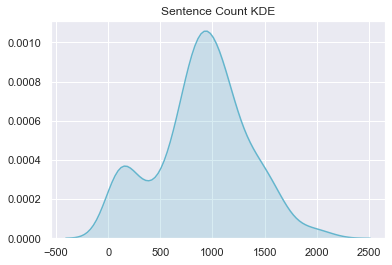

In [11]:
# Stats and KDE plot for sentence count
x = [len(x) for x in df.sentences]
ax = sns.kdeplot(x, shade=True, color="c")
ax.set_title('Sentence Count KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 9672.650306748466
SD: 4072.3942258179486


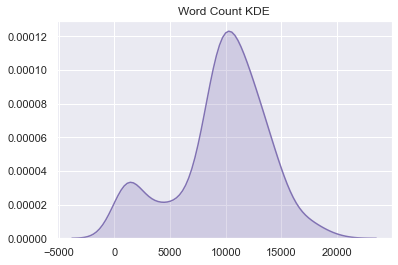

In [12]:
# Stats and KDE plot for word count
x = [len(x) for x in df.words]
ax = sns.kdeplot(x, shade=True, color="m")
ax.set_title('Word Count KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Perform sentiment analysis with TextBlob

In [13]:
# Sentiment analysis: Gather polarity and subjectivity values at the sentence and word levels
from textblob import TextBlob
from string import punctuation

def get_sentiment(series):
    pol = []
    sub = []
    for s in series:
        pol_per_comedian = []
        sub_per_comedian = []
        for item in s:
            item = item.lower()
            item = re.sub('\[.*?\]', '', item)
            item = re.sub('[%s]' % re.escape(punctuation), '', item)
            blob = TextBlob(item)
            pol_per_comedian.append(blob.polarity)
            sub_per_comedian.append(blob.subjectivity)
        pol.append(np.array(pol_per_comedian))
        sub.append(np.array(sub_per_comedian))
    pol_sub_dict = {'polarity': pol, 'subjectivity': sub}
    return pol_sub_dict

sent_pol_sub_dict = get_sentiment(df.sentences)
word_pol_sub_dict = get_sentiment(df.words)

df['sent_polarity'] = sent_pol_sub_dict['polarity']
df['sent_subjectivity'] = sent_pol_sub_dict['subjectivity']
df['word_polarity'] = word_pol_sub_dict['polarity']
df['word_subjectivity'] = word_pol_sub_dict['subjectivity']

df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,sentences,words,sent_polarity,sent_subjectivity,word_polarity,word_subjectivity
0,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESENT...,en,68.0,7.7,[TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESEN...,"[TAKE, ME, OUT, BY, FRANZ, FERDINAND, PLAYING,...","[0.8, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...","[0.9, 0.0, 0.0, 0.06666666666666667, 0.0, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,T.J. Miller: No Real Reason,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/t-j-m...,T.J. Miller,2011.0,"– I wish I didnt have to do this to perform, b...",en,67.0,7.1,"[– I wish I didnt have to do this to perform, ...","[–, I, wish, I, didnt, have, to, do, this, to,...","[0.1, -0.6999999999999998, -0.6999999999999998...","[1.0, 0.6666666666666666, 0.6666666666666666, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Jerry Seinfeld: 23 Hours To Kill,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/jerry...,Jerry Seinfeld,2020.0,"Jerry Seinfelds new hourlong comedy special, J...",en,60.0,6.7,"[Jerry Seinfelds new hourlong comedy special, ...","[Jerry, Seinfelds, new, hourlong, comedy, spec...","[0.29783549783549784, 0.0, 0.24285714285714285...","[0.47532467532467537, 0.0, 0.3678571428571429,...","[0.0, 0.0, 0.13636363636363635, 0.0, 0.0, 0.35...","[0.0, 0.0, 0.45454545454545453, 0.0, 0.0, 0.57..."
3,Bill Burr On The Late Show With David Letterma...,"May 5th, 2020",https://scrapsfromtheloft.com/2020/05/05/bill-...,Bill Burr,2010.0,Bill Burr performing on The Late Show with Dav...,en,NaN,NaN,[Bill Burr performing on The Late Show with Da...,"[Bill, Burr, performing, on, The, Late, Show, ...","[-0.3, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.6, 0.6333333333333333, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.3, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, ..."
4,Sincerely Louis Ck,"May 2nd, 2020",https://scrapsfromtheloft.com/2020/05/02/since...,Louis C.K.,2020.0,Great comedy is finally back. Louis C.K. is no...,en,60.0,8.5,"[Great comedy is finally back., Louis C.K., is...","[Great, comedy, is, finally, back, ., Louis, C...","[0.4, 0.0, 0.3, -0.5, 0.025000000000000022, 0....","[0.375, 0.0, 0.9, 0.5, 0.7, 0.2, 0.0, 0.0, 0.0...","[0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.75, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [14]:
df['word_count'] = df.words.apply(lambda x: len(x))
df['sent_count'] = df.sentences.apply(lambda x: len(x))
df['words_per_sentence'] = df.word_count / df.sent_count

df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,sentences,words,sent_polarity,sent_subjectivity,word_polarity,word_subjectivity,word_count,sent_count,words_per_sentence
0,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESENT...,en,68.0,7.7,[TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESEN...,"[TAKE, ME, OUT, BY, FRANZ, FERDINAND, PLAYING,...","[0.8, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...","[0.9, 0.0, 0.0, 0.06666666666666667, 0.0, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14238,1609,8.848975
1,T.J. Miller: No Real Reason,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/t-j-m...,T.J. Miller,2011.0,"– I wish I didnt have to do this to perform, b...",en,67.0,7.1,"[– I wish I didnt have to do this to perform, ...","[–, I, wish, I, didnt, have, to, do, this, to,...","[0.1, -0.6999999999999998, -0.6999999999999998...","[1.0, 0.6666666666666666, 0.6666666666666666, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10789,922,11.701735
2,Jerry Seinfeld: 23 Hours To Kill,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/jerry...,Jerry Seinfeld,2020.0,"Jerry Seinfelds new hourlong comedy special, J...",en,60.0,6.7,"[Jerry Seinfelds new hourlong comedy special, ...","[Jerry, Seinfelds, new, hourlong, comedy, spec...","[0.29783549783549784, 0.0, 0.24285714285714285...","[0.47532467532467537, 0.0, 0.3678571428571429,...","[0.0, 0.0, 0.13636363636363635, 0.0, 0.0, 0.35...","[0.0, 0.0, 0.45454545454545453, 0.0, 0.0, 0.57...",9500,942,10.084926
3,Bill Burr On The Late Show With David Letterma...,"May 5th, 2020",https://scrapsfromtheloft.com/2020/05/05/bill-...,Bill Burr,2010.0,Bill Burr performing on The Late Show with Dav...,en,NaN,NaN,[Bill Burr performing on The Late Show with Da...,"[Bill, Burr, performing, on, The, Late, Show, ...","[-0.3, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.6, 0.6333333333333333, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.3, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, ...",1072,113,9.486726
4,Sincerely Louis Ck,"May 2nd, 2020",https://scrapsfromtheloft.com/2020/05/02/since...,Louis C.K.,2020.0,Great comedy is finally back. Louis C.K. is no...,en,60.0,8.5,"[Great comedy is finally back., Louis C.K., is...","[Great, comedy, is, finally, back, ., Louis, C...","[0.4, 0.0, 0.3, -0.5, 0.025000000000000022, 0....","[0.375, 0.0, 0.9, 0.5, 0.7, 0.2, 0.0, 0.0, 0.0...","[0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.75, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9946,897,11.088071


Mean: 0.02398313933872448
SD: 0.028179182801992102


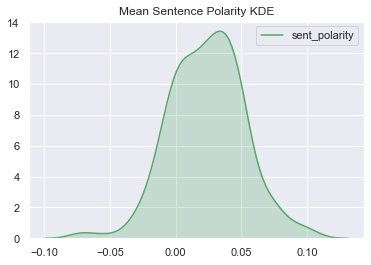

In [15]:
mean_sent_polarity = df.sent_polarity.apply(lambda x: x.mean())

ax = sns.kdeplot(mean_sent_polarity, shade=True, color="g")
ax.set_title('Mean Sentence Polarity KDE')
mean = mean_sent_polarity.mean()
sd = mean_sent_polarity.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 11.267627191396361
SD: 2.755884501433933


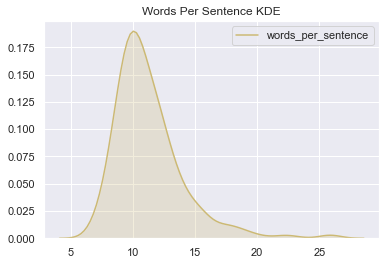

In [16]:
ax = sns.kdeplot(df.words_per_sentence, shade=True, color="y")
ax.set_title('Words Per Sentence KDE')
mean = df.words_per_sentence.mean()
sd = df.words_per_sentence.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Count the number of times an 'F' or 'S' word is used

In [17]:
def get_swear_counts(input_list, swear_list):
    swears = 0
    for word in input_list:
        if word.lower()in swear_list:
            swears += 1
    return swears

f_words = ['fuck', 'fucking', 'fuckin', 'fucker', 'fucka']
s_words = ['shit', 'shitter', 'shitting', 'shite']

df['f_words'] = df.words.apply(lambda x: get_swear_counts(x, f_words))
df['s_words'] = df.words.apply(lambda x: get_swear_counts(x, s_words))

df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,sentences,words,sent_polarity,sent_subjectivity,word_polarity,word_subjectivity,word_count,sent_count,words_per_sentence,f_words,s_words
0,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESENT...,en,68.0,7.7,[TAKE ME OUT BY FRANZ FERDINAND PLAYING PRESEN...,"[TAKE, ME, OUT, BY, FRANZ, FERDINAND, PLAYING,...","[0.8, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...","[0.9, 0.0, 0.0, 0.06666666666666667, 0.0, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14238,1609,8.848975,95,8
1,T.J. Miller: No Real Reason,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/t-j-m...,T.J. Miller,2011.0,"– I wish I didnt have to do this to perform, b...",en,67.0,7.1,"[– I wish I didnt have to do this to perform, ...","[–, I, wish, I, didnt, have, to, do, this, to,...","[0.1, -0.6999999999999998, -0.6999999999999998...","[1.0, 0.6666666666666666, 0.6666666666666666, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10789,922,11.701735,11,2
2,Jerry Seinfeld: 23 Hours To Kill,"May 6th, 2020",https://scrapsfromtheloft.com/2020/05/06/jerry...,Jerry Seinfeld,2020.0,"Jerry Seinfelds new hourlong comedy special, J...",en,60.0,6.7,"[Jerry Seinfelds new hourlong comedy special, ...","[Jerry, Seinfelds, new, hourlong, comedy, spec...","[0.29783549783549784, 0.0, 0.24285714285714285...","[0.47532467532467537, 0.0, 0.3678571428571429,...","[0.0, 0.0, 0.13636363636363635, 0.0, 0.0, 0.35...","[0.0, 0.0, 0.45454545454545453, 0.0, 0.0, 0.57...",9500,942,10.084926,0,0
3,Bill Burr On The Late Show With David Letterma...,"May 5th, 2020",https://scrapsfromtheloft.com/2020/05/05/bill-...,Bill Burr,2010.0,Bill Burr performing on The Late Show with Dav...,en,NaN,NaN,[Bill Burr performing on The Late Show with Da...,"[Bill, Burr, performing, on, The, Late, Show, ...","[-0.3, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.6, 0.6333333333333333, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.3, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, ...",1072,113,9.486726,0,0
4,Sincerely Louis Ck,"May 2nd, 2020",https://scrapsfromtheloft.com/2020/05/02/since...,Louis C.K.,2020.0,Great comedy is finally back. Louis C.K. is no...,en,60.0,8.5,"[Great comedy is finally back., Louis C.K., is...","[Great, comedy, is, finally, back, ., Louis, C...","[0.4, 0.0, 0.3, -0.5, 0.025000000000000022, 0....","[0.375, 0.0, 0.9, 0.5, 0.7, 0.2, 0.0, 0.0, 0.0...","[0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.75, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9946,897,11.088071,93,19


Mean: 41.45705521472393
SD: 45.174700161552515


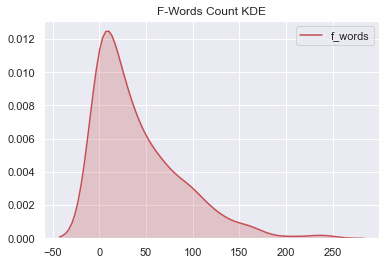

In [18]:
ax = sns.kdeplot(df.f_words, shade=True, color="r")
ax.set_title('F-Words Count KDE')
mean = df.f_words.mean()
sd = df.f_words.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 22.288343558282207
SD: 28.746472463485187


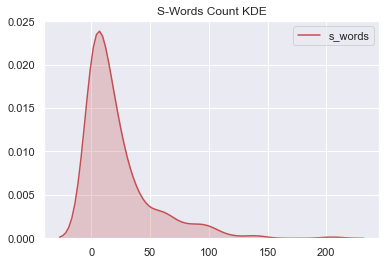

In [19]:
ax = sns.kdeplot(df.s_words, shade=True, color="r")
ax.set_title('S-Words Count KDE')
mean = df.s_words.mean()
sd = df.s_words.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Save data into a csv file for more analysis later on

In [20]:
# Save DataFrame to the current drectory
df.to_csv(r'./stand-up-data-cleaned.csv', index=False)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               326 non-null    object 
 1   date_posted         326 non-null    object 
 2   link                326 non-null    object 
 3   name                322 non-null    object 
 4   year                309 non-null    float64
 5   transcript          326 non-null    object 
 6   language            326 non-null    object 
 7   runtime             275 non-null    float64
 8   rating              275 non-null    float64
 9   sentences           326 non-null    object 
 10  words               326 non-null    object 
 11  sent_polarity       326 non-null    object 
 12  sent_subjectivity   326 non-null    object 
 13  word_polarity       326 non-null    object 
 14  word_subjectivity   326 non-null    object 
 15  word_count          326 non-null    int64  
 16  sent_cou